# Project - Distributed Algorithms
# Dimensionality reduction

In [1]:
from dask.distributed import Client
import dask.array as da

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import time
from sklearn import datasets

## CLUSTER

We have created a cluster where 1 virtual machine acts as a schedueler and a worker and the other two VM are only workers.

In [2]:
in_remote = True
in_local = False

if in_remote:
    client = Client('10.67.22.67:8786') # solo la porta dello scheduler
    client

if in_local:
    client = Client('dask-scheduler:8786')
    client

In [3]:
client

<Client: 'tcp://10.67.22.67:8786' processes=3 threads=12, memory=23.29 GiB>

## QR DECOMPOSITION

### Definition

Factorize $A$ matrix in $$A = QR$$

- $A$ matrix *m x n*
- $Q$ orthogonal matrix *m x n*
- $R$ upper triangular matrix *n x n*


### Indirect method

We are working with *tall and skinny* matrices: $m >> n$.


The matrix $R$ is fast computed with MapReduce methods, instead the matrix $Q$ is computed **indirectly** as $$Q = AR^{-1}$$ for $R$ invertible and $A$ full rank.

This method is numerically unstable since the calculated Q is not exactly orthogonal. To measure this error, we use: $$ || Q^{T}Q - I||_2$$



### Direct method (TSQR)

In https://arxiv.org/abs/1301.1071 they propose a *direct* method for calculating Q which is not unstable called *DIRECT TSQR*. 

The main goal of this project is to implement this method and check its performance with two success metrics:

- *accuracy* of decomposition, we use     $||A − QR||_2/|R|_2$
- *orthogonality* of computed $Q$ factor, we use     $|| Q^{T}Q - I||_2$

The ideal value for both metrics is 0.

#### First step: `Map tasks`
We are going to work with dask arrays.

- Divide the data in different chunks such that $A_i$ is $\frac{m}{n_{blocks}}\times n$. Since the matrix is tall and skinny, the chunks consist in all the columns and a certain number of rows. (For explanatory purposes we divide A in four blocks)
- Compute QR decomposition and emit $Q$ and $R$ separately for each block

$$
A = \left [ \begin{matrix}
   A_1 \\
   A_2 \\
   A_3 \\
   A_4 \\
\end{matrix}\right ]
=\left [ \begin{matrix}
   Q_1 & 0 & 0 & 0 \\
    0 & Q_2 & 0 & 0 \\
    0 & 0 & Q_3 & 0 \\
    0 & 0 & 0 & Q_4 \\
\end{matrix} \right ]
\quad
\left [ \begin{matrix}
   R_1 \\
   R_2 \\
   R_3 \\
   R_4 \\
\end{matrix} \right ]
$$

#### Second step: `Reduce task`

- The input is the set of $R$ factors from the first step
- $R$ factors are collected as a matrix
- Compute QR decomposition and emit $Q$ factor
- $\tilde{R}$ is the final $R$ matrix of the whole QR decomposition

$$
\left [ \begin{matrix}
    R_1 \\
    R_2 \\
    R_3 \\
    R_4 \\
\end{matrix} \right ] = \left [ \begin{matrix}
    Q^2_1 \\
    Q^2_2 \\
    Q^2_3 \\
    Q^2_4 \\
\end{matrix} \right ]
\tilde{R}
$$

#### Third step: `Map tasks`

- The input is the set of $Q$ factors from the first step
- $Q^2$ factors are distributed to all map tasks
- Multiply the corresponding $Q$ factors from first and second step and emit the final $Q$

$$
Q = \left [ \begin{matrix}
   Q_1 & 0 & 0 & 0 \\
    0 & Q_2 & 0 & 0 \\
    0 & 0 & Q_3 & 0 \\
    0 & 0 & 0 & Q_4 \\
\end{matrix} \right ]
\quad
\left [ \begin{matrix}
   Q^2_1 \\
   Q^2_2 \\
   Q^2_3 \\
   Q^2_4 \\
\end{matrix} \right ]
=
\left [ \begin{matrix}
   Q_1 Q^2_1 \\
   Q_2 Q^2_2 \\
   Q_3 Q^2_3 \\
   Q_4 Q^2_4 \\
\end{matrix} \right ]
$$

In [4]:
def direct_TSQR(data,num_blocks,is_random):
    
    ## FIRST STEP    
    if is_random:
        dA = data # input is already a dask array
        
        dim = data.shape
        columns = dim[1]
        rows = dim[0]
        rows_per_block = rows//num_blocks  # how many rows each block has

        chunk_list = [rows_per_block]*num_blocks
        chunk_list[-1] = rows_per_block - (rows_per_block*num_blocks - rows)
        chunk_list = tuple(chunk_list)
        
        dA = data.rechunk((chunk_list, (columns,)))
        dask_housing = dA
    else:
        
        dim = data.shape
        columns = dim[1]
        rows = dim[0]
        rows_per_block = rows//num_blocks  # how many rows each block has

        chunk_list = [rows_per_block]*num_blocks
        chunk_list[-1] = rows_per_block - (rows_per_block*num_blocks - rows)
        chunk_list = tuple(chunk_list)
        
        dA = da.from_array(data, chunks=((chunk_list, (columns,)))) #divide the data in bloks (create dask array)
        dask_housing = dA
    
    step1_R = dA.map_blocks(lambda x: np.linalg.qr(x)[1],chunks=(columns,columns)) #calculate every R_i.
    
    step1_Q =dA.map_blocks(lambda x: np.linalg.qr(x)[0],chunks=(chunk_list,(columns,))) #calculate every Q_i 
    ##!!The final shape is a column block matrix (such as with R_i) not a diagonal block matrix 
    ##(as displayed in the theoretical explanaiton)!!
    
    ##SECOND STEP
    input_R = step1_R.rechunk(num_blocks*columns,columns) ## Merge the diferent blocks R_i into a unique block R
    R = np.linalg.qr(input_R)[1] # Calculate final R. No need for map_block since there is no block partition
    
    step2_Q = input_R.map_blocks(lambda x: np.linalg.qr(x)[0],chunks=(num_blocks*columns,columns)).rechunk(columns,columns)
    ## Again column block matrix of Q^2_i
    
    ##THIRD SETP
    Q = da.map_blocks(lambda x,y: np.matmul(x,y),step1_Q,step2_Q) #matrix multiplication block by block. 
    return(dask_housing, Q, R)

In [5]:
### Succes metrics
def accuracy(data,Q,R):
    accuracy = da.linalg.norm(data - da.matmul(Q, R))/da.linalg.norm(R)
    return(accuracy)
def orthogonality(Q):
    columns=Q.shape[1]
    ortho= da.linalg.norm(da.matmul(Q.T, Q)- np.eye(columns))
    return(ortho)

## DATA

We will work with two different data:
- California housing dataset (from sklearn)
- Random generated matrices of different sizes.

We choose to work also with the second kind since the first dataset is small.


In [6]:
## Housing data
data_house = datasets.fetch_california_housing()
df = pd.DataFrame(data=data_house.data, columns=data_house.feature_names)
data_matrix = np.array(df)

In [7]:
print(data_matrix.shape)

(20640, 8)


In [8]:
## random data
def random_data(rows,columns):
    dask_random= da.random.random((rows,columns))
    return(dask_random)

## RESULTS

First of all we want to have a look at our algorithm for a simple example such as housing data and 4 blocks.


In [9]:
num_blocks_example = 4
A_example, Q_example,R_example=direct_TSQR(data_matrix, num_blocks_example, is_random = False)

In [10]:
A_example

dask.array<array, shape=(20640, 8), dtype=float64, chunksize=(5160, 8), chunktype=numpy.ndarray>

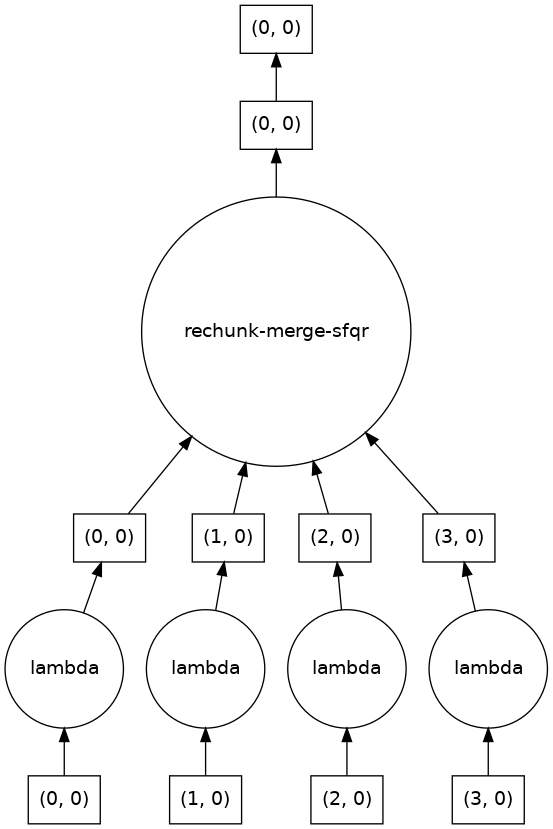

In [11]:
R_example.visualize(optimize_graph=True)

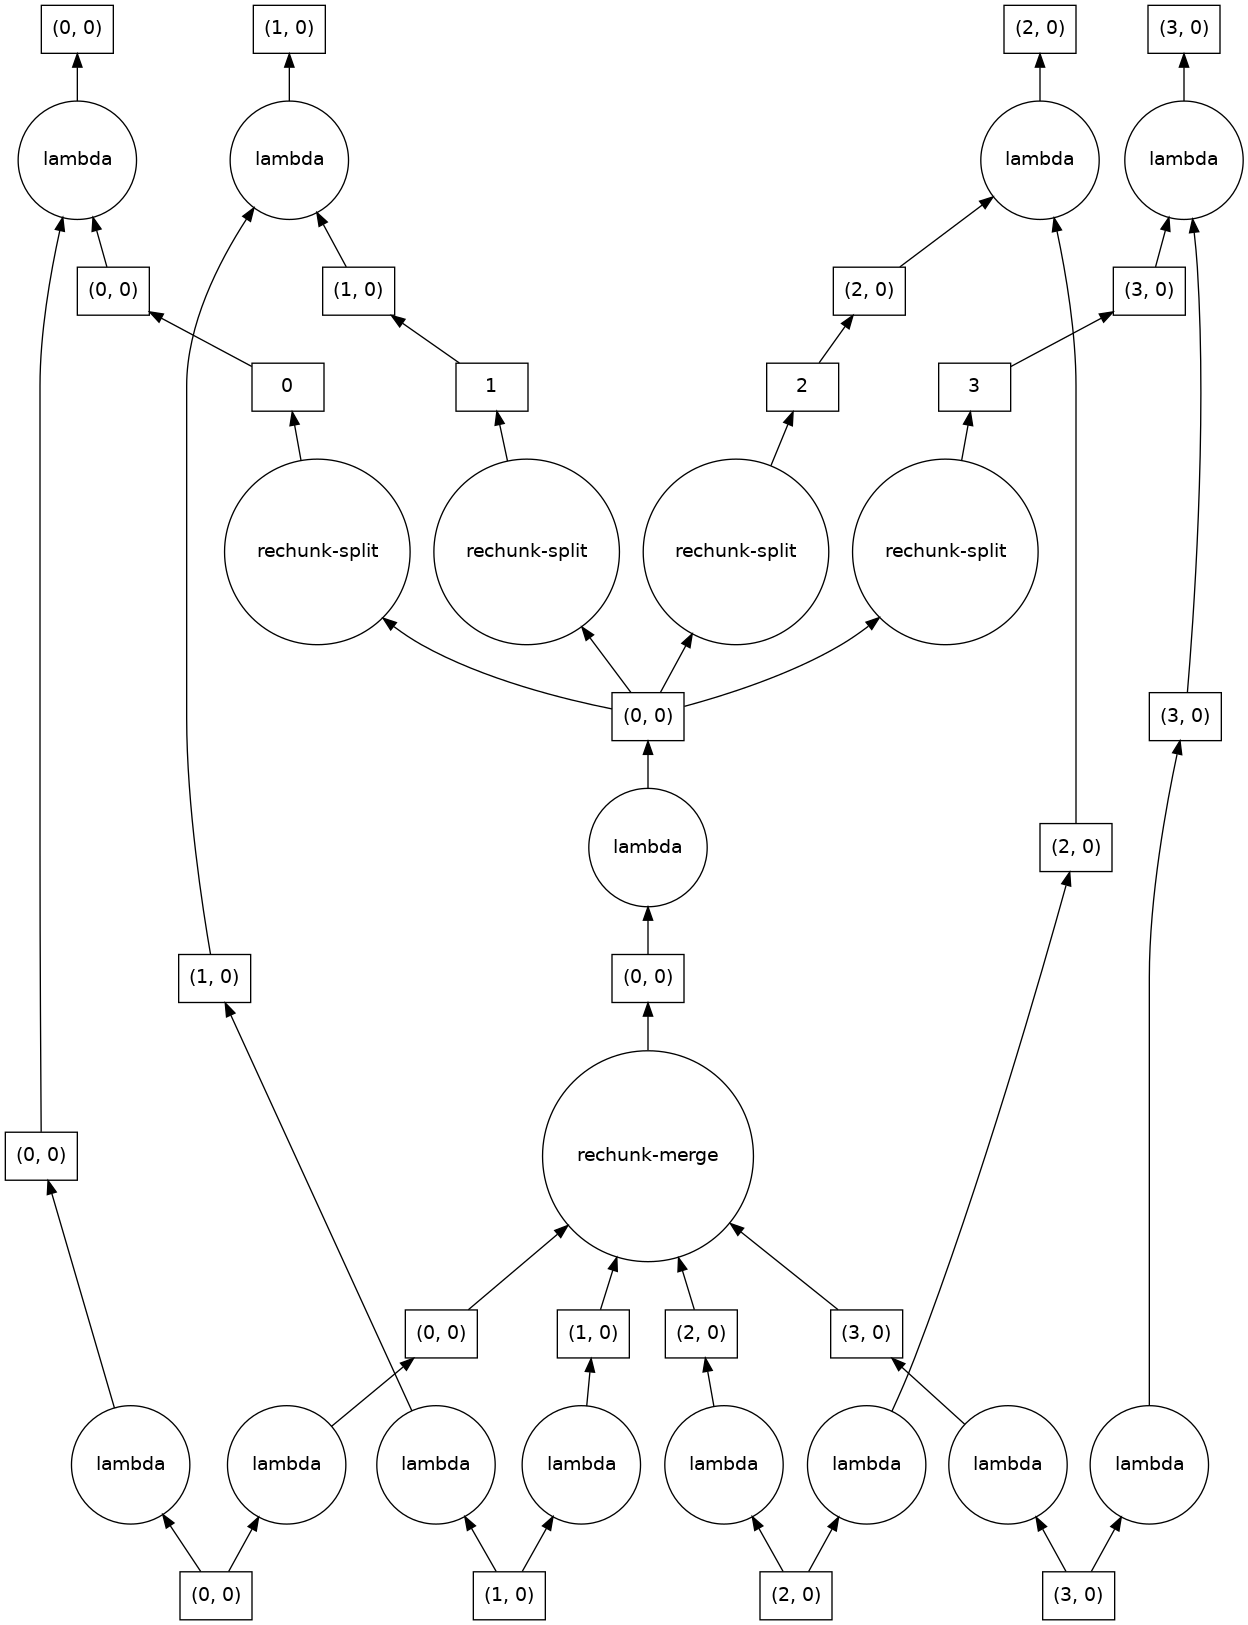

In [12]:
Q_example.visualize()

The next step is to check if different number of blocks yield good results regarding our success metrics.  

We will use the housing data.

In [13]:
num_blocks_list = [2,4,10,20,50,100,150]
accuracy_list = np.zeros(len(num_blocks_list))
orthogonality_list = np.zeros(len(num_blocks_list))

for i in range(len(num_blocks_list)):
    dask_housing, Q, R = direct_TSQR(data_matrix, num_blocks_list[i], is_random = False)
    accuracy_list[i] = accuracy(dask_housing, Q, R).compute()
    orthogonality_list[i] = orthogonality(Q).compute()


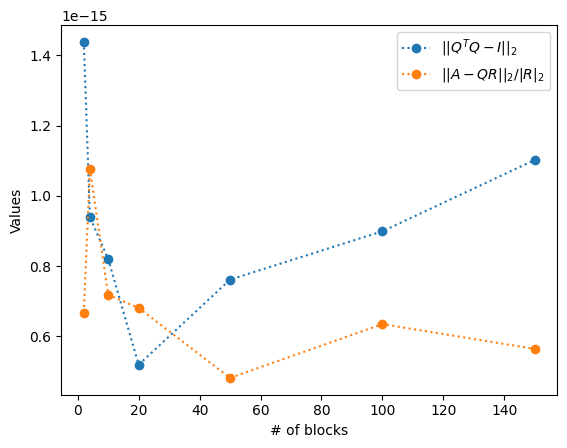

In [14]:
plt.plot(num_blocks_list, orthogonality_list, 'o', linestyle='dotted',label='$|| Q^{T}Q - I||_2$')
plt.plot(num_blocks_list, accuracy_list, 'o', linestyle='dotted',label='$||A − QR||_2/|R|_2$')
plt.xlabel('# of blocks')
plt.ylabel('Values')
plt.legend()
plt.show()

In [15]:
Q_n, R_n=np.linalg.qr(data_matrix)
ortho_normal=np.linalg.norm(Q_n.T@Q_n - np.eye(Q_n.shape[1]))
acc_normal=np.linalg.norm(Q_n@R_n - data_matrix)

In [16]:
print('Accuracy for non parallelized QR decomposition:',acc_normal)
print('\nOrthogonality for non parallelized QR decomposition:',ortho_normal)

Accuracy for non parallelized QR decomposition: 3.8411128465152366e-10

Orthogonality for non parallelized QR decomposition: 1.061363730872079e-15


Even though the best choice seems to be 20 blocks, all the different partitions yield really good results of the order of $10^{-15}$. We can see also that the direct TSQR method is more accurate than the non parallelized QR.  


Knowing that all partitions are correct, we want to find which one is the fastest.

In [17]:
num_blocks_list=[2,4,10,20,50,100,150]
time_list=np.zeros(len(num_blocks_list))
for i in range(len(num_blocks_list)):
    start = time.time()
    A, Q, R = direct_TSQR(data_matrix,num_blocks_list[i], is_random = False)
    R_ = R.compute()
    Q_ = Q.compute()
    end = time.time()
    time_list[i] = ((end - start)*1000)
    

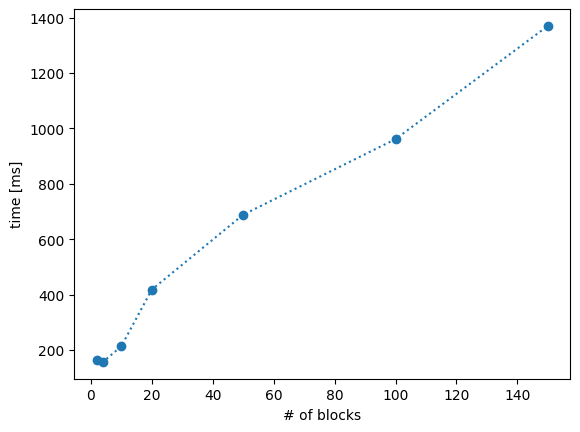

In [18]:
plt.plot(num_blocks_list, time_list, 'o', linestyle='dotted')
plt.xlabel('# of blocks')
plt.ylabel('time [ms]')
plt.show()

In [19]:
start = time.time()

normal_qr=np.linalg.qr(data_matrix)

end = time.time()
time_normal=((end - start)*1000)

In [20]:
print('Minimum time for direct TSQR:',round(min(time_list)),'ms')
print('\nTime for normal QR decomposition (no partition):',round(time_normal),'ms')

Minimum time for direct TSQR: 157 ms

Time for normal QR decomposition (no partition): 9 ms


We can observe that the less number of blocks the better. In fact doing no partition at all is way faster. This is due to the time required to split the data and schedule the tasks. Theoretically the implemented algotirthm should be faster than the regular QR decomposition for bigger datasets. To prove so we are going to work with bigger matrices generated randomly. We will fix the number of columns and vary the number of rows since we are constantly working with tall and skinny matrices.

### Random matrices

From now on we want to make a differentiation between using the numpy function qr, which does not take advantage of the parallelization and its adaptation to dask. The second one uses parallelization but it is different from the algorithm that we have implemented.  
We will call them as follows:
- **numpy.linalg.qr** (no parallelization): Normal QR
- **dask.array.linalg.qr** (adaptation of numpy function to dask): Dask QR
- The implemented algorithm: **Direct TSQR** (as before)



We shall start as before, searching which is the best number of blocks for our algorithm. Later we will be able to compare all 3 methods.

In [21]:
np.random.seed=1234
#create data:
rows = int(1e6)
columns = 20
data = random_data(rows,columns)

num_blocks_list = [2,4,10,20,50,100,150]
accuracy_list = np.zeros(len(num_blocks_list))
orthogonality_list = np.zeros(len(num_blocks_list))

for i in range(len(num_blocks_list)):
    A, Q, R = direct_TSQR(data, num_blocks_list[i], is_random = True)
    accuracy_list[i] = accuracy(data, Q, R).compute()
    orthogonality_list[i] = orthogonality(Q).compute()


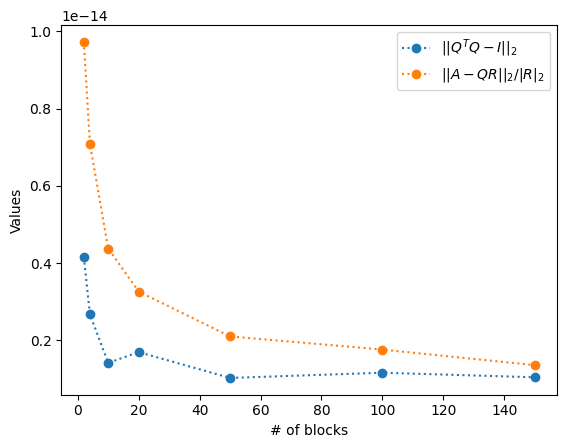

In [22]:
plt.plot(num_blocks_list, orthogonality_list, 'o', linestyle='dotted',label='$|| Q^{T}Q - I||_2$')
plt.plot(num_blocks_list, accuracy_list, 'o', linestyle='dotted',label='$||A − QR||_2/|R|_2$')
plt.xlabel('# of blocks')
plt.ylabel('Values')
plt.legend()
plt.show()

In [23]:
Q,R = da.linalg.qr(data)
acc_dask = accuracy(data, Q, R).compute()
ortho_dask = orthogonality(Q).compute()

In [24]:
print('Accuracy for dask QR:',acc_dask)
print('\nOrthogonality for dask QR:',ortho_dask)

Accuracy for dask QR: 1.0534676308342375e-14

Orthogonality for dask QR: 5.3452581733330146e-15


We can see that now the success metrics get better with more partitions. Nevertheless the values are good for all type of divisions.

The accuracy for the dask QR seems worse than for the direct method.

In [25]:
num_blocks_list=[2,4,10,20,50,100,150]
time_list=np.zeros(len(num_blocks_list))
for i in range(len(num_blocks_list)):
    start = time.time()
    A, Q, R = direct_TSQR(data, num_blocks_list[i], is_random = True)
    R_ = R.compute()
    Q_ = Q.compute()
    end = time.time()
    time_list[i] = ((end - start)*1000)
    

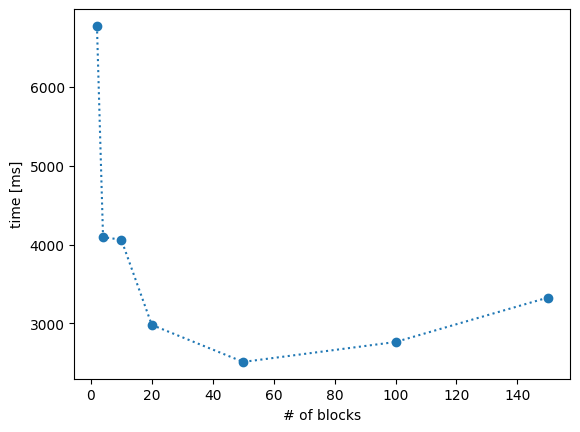

In [26]:
plt.plot(num_blocks_list, time_list, 'o', linestyle='dotted')
plt.xlabel('# of blocks')
plt.ylabel('time [ms]')
plt.show()

In this case we can see that there is a minimum for 50 blocks. This corresponds to taking around 20 000 rows per every block. We will use this value as reference when scaling the dataset size.

In [27]:
np.random.seed=1234
rows_list=np.array([1e5,5e5,1e6,5e6,1e7]) ## 1e8??


rows_per_block = 20000 ### Value calculated previously
num_blocks = rows_list//rows_per_block

time_list_direct = np.zeros(len(rows_list))
time_list_normal = np.zeros(len(rows_list[rows_list<1e6]))
time_list_dask = np.zeros(len(rows_list))

accuracy_list_direct=np.zeros(len(rows_list))
orthogonality_list_direct=np.zeros(len(rows_list))
accuracy_list_dask=np.zeros(len(rows_list))
orthogonality_list_dask=np.zeros(len(rows_list))

for i in range(len(rows_list)):
    data = random_data(int(rows_list[i]), columns)
    #direct TSQR
    
    start = time.time()
    A, Q, R=direct_TSQR(data, int(num_blocks[i]), is_random = True)
    Q_ = Q.compute()
    R_ = R.compute()
    end = time.time()
    time_list_direct[i] = ((end - start)*1000)
    accuracy_list_direct[i] = accuracy(data, Q, R).compute()
    orthogonality_list_direct[i] = orthogonality(Q).compute()

    
    #dask qr
    start = time.time()
    Q,R=da.linalg.qr(data)
    Q_ = Q.compute()
    R_ = R.compute()
    end = time.time()
    time_list_dask[i] = ((end - start)*1000)
    accuracy_list_dask[i] = accuracy(data, Q, R).compute()
    orthogonality_list_dask[i] = orthogonality(Q).compute()

    
    #normal qr
    if rows_list[i]<1e6: ## for bigger matrices normal qr can not compute
        numpy_data=np.random.random((int(rows_list[i]),columns))
        start = time.time()
        Q,R=np.linalg.qr(numpy_data) 
        end = time.time()
        time_list_normal[i]=((end - start)*1000)       

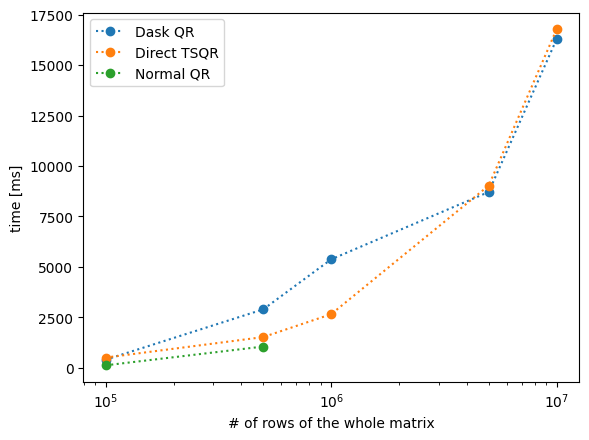

In [28]:
plt.plot(rows_list,time_list_dask,'o', linestyle='dotted',label='Dask QR')
plt.plot(rows_list,time_list_direct,'o', linestyle='dotted',label='Direct TSQR')
plt.plot(rows_list[rows_list<1e6],time_list_normal,'o', linestyle='dotted',label='Normal QR')
plt.xscale('log')
plt.xlabel('# of rows of the whole matrix')
plt.ylabel('time [ms]')
plt.legend()
plt.show()

The fastest method is still without parallelizing for the same reason we mentioned before. The downside of this method is that it can not operate with too heavy matrices.   
On the other hand,for both methods that use parallelization, Direct TSQR seems faster for smaller datasets but slower for bigger ones.

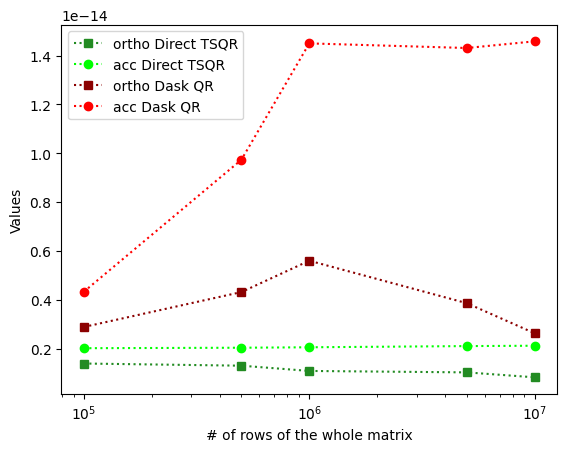

In [29]:
plt.plot(rows_list, orthogonality_list_direct,'s', linestyle='dotted',label='ortho Direct TSQR',color='forestgreen')
plt.plot(rows_list, accuracy_list_direct, 'o', linestyle='dotted',label='acc Direct TSQR',color='lime')

plt.plot(rows_list, orthogonality_list_dask, 's', linestyle='dotted',label='ortho Dask QR',color='darkred')
plt.plot(rows_list, accuracy_list_dask, 'o', linestyle='dotted',label='acc Dask QR',color='red')

plt.xscale('log')
plt.xlabel('# of rows of the whole matrix')
plt.ylabel('Values')
plt.legend()
plt.show()

We can check that the succes matrices are more stable for the Direct TSQR. Moreover the accuracy is significantly better for the Direct TSQR with respect to Dask QR.

Lastly we would like to try using one persist to see if the time reduces.

In [30]:
def direct_TSQR_persist(data,num_blocks,is_random):
    
    ## FIRST STEP    
    if is_random:
        dA = data
        
        dim = data.shape
        columns = dim[1]
        rows = dim[0]
        rows_per_block = rows//num_blocks  # how many rows each block has

        chunk_list = [rows_per_block]*num_blocks
        chunk_list[-1] = rows_per_block - (rows_per_block*num_blocks - rows)
        chunk_list = tuple(chunk_list)
        
        dA = data.rechunk((chunk_list, (columns,)))
        dask_housing = dA
    else:
        
        dim = data.shape
        columns = dim[1]
        rows = dim[0]
        rows_per_block = rows//num_blocks  # how many rows each block has

        chunk_list = [rows_per_block]*num_blocks
        chunk_list[-1] = rows_per_block - (rows_per_block*num_blocks - rows)
        chunk_list = tuple(chunk_list)
        
        dA = da.from_array(data, chunks=((chunk_list, (columns,)))) #divide the data in bloks
        dask_housing = dA
    
    step1_R = dA.map_blocks(lambda x: np.linalg.qr(x)[1],chunks=(columns,columns)) #calculate every R_i.
    
    step1_Q =dA.map_blocks(lambda x: np.linalg.qr(x)[0],chunks=(chunk_list,(columns,))) #calculate every Q_i 
    ##!!The final shape is a column block matrix (such as with R_i) not a diagonal block matrix 
    ##(as displayed in the theoretical explanaiton)!!
    
    ##SECOND STEP
    
    #### !!!! PERSIST!!!!
    input_R = step1_R.rechunk(num_blocks*columns,columns).persist() ## Merge the diferent blocks R_i into a unique block R
    ####
    
    
    R = np.linalg.qr(input_R)[1] # Calculate final R. No need for map_block since there is no block partition
    
    step2_Q = input_R.map_blocks(lambda x: np.linalg.qr(x)[0],chunks=(num_blocks*columns,columns)).rechunk(columns,columns)
    ## Again column block matrix of Q^2_i
    
    ##THIRD SETP
    Q = da.map_blocks(lambda x,y: np.matmul(x,y),step1_Q,step2_Q) #matrix multiplication block by block. 
    return(dask_housing, Q, R, input_R)

In [31]:
np.random.seed=1234
rows_list=np.array([1e5,5e5,1e6,5e6,1e7]) ## 1e8??


rows_per_block = 20000 ### Value calculated previously
num_blocks = rows_list//rows_per_block

time_list_persist = np.zeros(len(rows_list))
memory_relative = np.zeros(len(rows_list))
for i in range(len(rows_list)):
    
    #direct TSQR
    data = random_data(int(rows_list[i]), columns)
    start = time.time()
    A, Q, R, persisted = direct_TSQR_persist(data,int(num_blocks[i]), is_random = True)
    Q_ = Q.compute()
    R_ = R.compute()
    end = time.time()
    time_list_persist[i] = ((end - start)*1000)
    memory_relative[i] = persisted.nbytes/data.nbytes

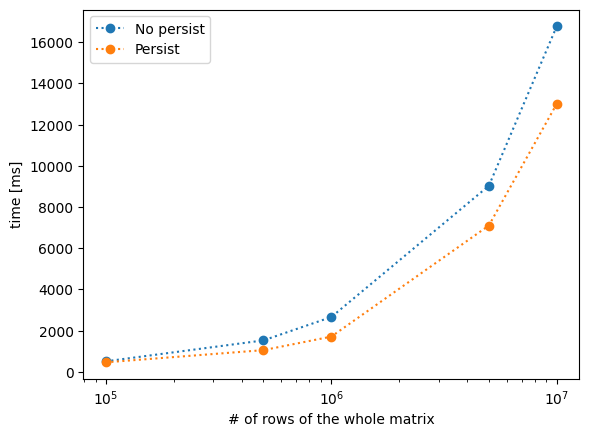

In [32]:
plt.plot(rows_list,time_list_direct,'o', linestyle='dotted',label='No persist')
plt.plot(rows_list,time_list_persist,'o', linestyle='dotted',label='Persist')
plt.xscale('log')
plt.xlabel('# of rows of the whole matrix')
plt.ylabel('time [ms]')
plt.legend()
plt.show()

In [33]:
memory_relative  ## should be always the same

array([0.001, 0.001, 0.001, 0.001, 0.001])

Using one persist lowers considerably the time and its memory usage is way lower of the original matrix.

In [ ]:
client.close()